<a href="https://colab.research.google.com/github/Justawayx/microbe_tracking/blob/master/RNN_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/image_segmentation/RNN

/content/drive/.shortcut-targets-by-id/1oL1IKgNdUkjyUG9U8GsIIiZwuLk7-0r1/image_segmentation/RNN


In [ ]:
#OLD bounding box detection, used as template

import numpy as np
import os
from PIL import Image
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))

def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def develop_features(folder_path, num_files):
    files = sorted([f for f in os.listdir(folder_path)])
    
    image = Image.open(folder_path + '/' + files[0])
    arr = np.array(image)
    arr = np.zeros(shape=(num_files, np.shape(arr)[0], np.shape(arr)[1]), dtype='uint8')

    i = 0
    for f in files:
        image = Image.open(folder_path + '/' + f).convert('L')
        arr[i, :, :] = np.asarray(image)
        i+=1

        if i == num_files:
            break
    
    m, n, o = arr.shape
    return np.reshape(arr, (m,n,o,1))


def develop_labels(features, filepath, max_cells = 0):

    with open(filepath, 'r') as f:
        #skip first line
        f.readline()

        prev_frame = -1
        current_frame = list()
        frames = list()
        firstIter = True
        for line in f:
            regionNum, clusterSize, frame, BB_1, BB_2, BB_3, BB_4 = line.split(',')
            

            if firstIter:
                prev_frame = frame

            if frame != prev_frame:
                prev_frame = frame
                current_frame = np.array(current_frame)
                max_cells = max(max_cells, np.shape(current_frame)[0])
                frames.append(current_frame)
                current_frame=list()
            
            firstIter = False

            current_frame.append((float(clusterSize), float(BB_1), float(BB_2), float(BB_3), float(BB_4)))

        current_frame = np.array(current_frame, dtype='uint8')
        max_cells = max(max_cells, np.shape(current_frame)[0])
        frames.append(current_frame)

        new_frames = list()

        for frame in frames:
            frame = np.pad(frame, ((0, max_cells - np.shape(frame)[0]), (0, 0)), constant_values=((0,0),(0,0)))
            new_frames.append(frame)

    return np.stack(new_frames, axis=0)


def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(dropout)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(dropout)

    return pool


def createModel(image_dim, max_boxes, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(block)
    reshape = tf.keras.layers.Reshape((64, 4))(conv)

    # #coord portion
    # inputs2 = tf.keras.layers.Input(shape=(4), dtype='float32')
    # repeat = tf.keras.layers.RepeatVector(64)(inputs2)
    # RNN = tf.keras.layers.SimpleRNN(4096, return_sequences=True, return_state=True, dropout=0.5)(repeat)
    # attention = tf.keras.layers.AdditiveAttention()(RNN)
    # dense = tf.keras.layers.Dense(16, activation='relu')(attention)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    # dense = tf.keras.layers.Dense(4, activation='relu')(dropout)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)

    #combined portion
    # merge = tf.keras.layers.concatenate([reshape, dropout])
    # dense = tf.keras.layers.Dense(4)(merge)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

max_boxes = 64
num_frames = 1500
features = develop_features('/content/drive/My Drive/image_segmentation/RNN/new_frames_jpg', num_frames)
print(features.shape)
labels = develop_labels(features, '/content/drive/My Drive/image_segmentation/RNN/FullRegionsInfo.csv', max_boxes)[:,:,1:]
print(labels.shape)

START = np.zeros((features.shape[0], 4))


model = createModel((1024, 1024), max_boxes, True)
model.fit(x=features,y=labels,batch_size=1,epochs=1,validation_split=0.1)


FileNotFoundError: ignored

In [ ]:
model.predict(x=[features, START])

array([[[2.7357724, 3.3977368, 3.3580081, 3.3577344],
        [3.370672 , 3.3780007, 3.385768 , 3.3874502],
        [3.3843906, 3.3816843, 3.3817854, 3.380593 ],
        ...,
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ]],

       [[2.7374396, 3.408521 , 3.3755915, 3.3700032],
        [3.3766782, 3.3905544, 3.389056 , 3.3888068],
        [3.3821478, 3.3804865, 3.3835309, 3.3891218],
        ...,
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ]],

       [[2.7408283, 3.4202   , 3.391798 , 3.3841305],
        [3.3814907, 3.3878543, 3.3979864, 3.4065175],
        [3.4111247, 3.415078 , 3.4104793, 3.4120004],
        ...,
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.      

In [ ]:
#slightly modified bounding box detection, still has errors

cd /content/drive/My\ Drive/cs168/

import numpy as np
import os
from PIL import Image
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))

def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def develop_features(folder_path, num_files):
    files = sorted([f for f in os.listdir(folder_path)])
    
    image = Image.open(folder_path + '/' + files[0])
    arr = np.array(image)
    arr = np.zeros(shape=(num_files, np.shape(arr)[0], np.shape(arr)[1]), dtype='uint8')

    i = 0
    for f in files:
        image = Image.open(folder_path + '/' + f).convert('L')
        arr[i, :, :] = np.asarray(image)
        i+=1

        if i == num_files:
            break
    
    m, n, o = arr.shape
    return np.reshape(arr, (m,n,o,1))


def develop_labels(features, filepath, max_cells = 0):

    with open(filepath, 'r') as f:
        #skip first line
        f.readline()

        prev_frame = -1
        current_frame = list()
        frames = list()
        firstIter = True
        for line in f:
            regionNum, clusterSize, frame, BB_1, BB_2, BB_3, BB_4 = line.split(',')
            

            if firstIter:
                prev_frame = frame

            if frame != prev_frame:
                prev_frame = frame
                current_frame = np.array(current_frame)
                max_cells = max(max_cells, np.shape(current_frame)[0])
                frames.append(current_frame)
                current_frame=list()
            
            firstIter = False

            current_frame.append((float(clusterSize), float(BB_1), float(BB_2), float(BB_3), float(BB_4)))

        current_frame = np.array(current_frame, dtype='uint8')
        max_cells = max(max_cells, np.shape(current_frame)[0])
        frames.append(current_frame)

        new_frames = list()

        for frame in frames:
            frame = np.pad(frame, ((0, max_cells - np.shape(frame)[0]), (0, 0)), constant_values=((0,0),(0,0)))
            new_frames.append(frame)

    return np.stack(new_frames, axis=0)


def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(dropout)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(dropout)

    return pool


def createModel(image_dim, max_boxes, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(block)
    reshape = tf.keras.layers.Reshape((64, 4))(conv)

    # #coord portion
    # inputs2 = tf.keras.layers.Input(shape=(4), dtype='float32')
    # repeat = tf.keras.layers.RepeatVector(64)(inputs2)
    # RNN = tf.keras.layers.SimpleRNN(4096, return_sequences=True, return_state=True, dropout=0.5)(repeat)
    # attention = tf.keras.layers.AdditiveAttention()(RNN)
    # dense = tf.keras.layers.Dense(16, activation='relu')(attention)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    # dense = tf.keras.layers.Dense(4, activation='relu')(dropout)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)

    #combined portion
    # merge = tf.keras.layers.concatenate([reshape, dropout])
    # dense = tf.keras.layers.Dense(4)(merge)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

max_boxes = 64
num_frames = 1500
features = develop_features('new_frames_jpg', num_frames)
print(features.shape)
labels = develop_labels(features, 'FullRegionsInfo.csv', max_boxes)[:,:,1:]
print(labels.shape)

START = np.zeros((features.shape[0], 4))


model = createModel((1024, 1024), max_boxes, True)
model.fit(x=features,y=labels,batch_size=1,epochs=1,validation_split=0.1)


SyntaxError: ignored

In [ ]:
# cell counting 1 with no filter, using old develop_features function

import numpy as np
import os
from PIL import Image
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))

def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def develop_features(folder_path, num_files):
    files = [f for f in os.listdir(folder_path)]
    
    image = Image.open(folder_path + '/' + files[0])
    arr = np.array(image)
    arr = np.zeros(shape=(num_files, np.shape(arr)[0], np.shape(arr)[1]), dtype='uint8')

    i = 0
    for f in files:
        image = Image.open(folder_path + '/' + f).convert('L')
        arr[i, :, :] = np.asarray(image)
        i+=1

        if i == num_files:
            break
    
    m, n, o = arr.shape
    return np.reshape(arr, (m,n,o,1))


def develop_labels(features, filepath, max_cells = 0):
    files = [f for f in os.listdir(filepath)]
    cells_per_frame = list()

    for fLoc in files: 
        numCells = 0;
        with open(filepath + '/' + fLoc) as f:
            f.readline()
            for line in f:
                numCells += 1;
        cells_per_frame.append(numCells)

    return np.stack(cells_per_frame, axis=0)

def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(dropout)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(dropout)

    return pool


def createModel(image_dim, max_boxes, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(block)
    reshape = tf.keras.layers.Flatten()(conv)
    reshape = tf.keras.layers.Dense(1)(reshape)

    print(reshape.shape)
    # reshape = tf.keras.layers.Reshape((64, 4))(conv)
    # reshape = tf.keras.layers.Dense(1)(reshape)

    # #coord portion
    # inputs2 = tf.keras.layers.Input(shape=(4), dtype='float32')
    # repeat = tf.keras.layers.RepeatVector(64)(inputs2)
    # RNN = tf.keras.layers.SimpleRNN(4096, return_sequences=True, return_state=True, dropout=0.5)(repeat)
    # attention = tf.keras.layers.AdditiveAttention()(RNN)
    # dense = tf.keras.layers.Dense(16, activation='relu')(attention)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    # dense = tf.keras.layers.Dense(4, activation='relu')(dropout)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)

    #combined portion
    # merge = tf.keras.layers.concatenate([reshape, dropout])
    # dense = tf.keras.layers.Dense(4)(merge)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

max_boxes = 64
num_frames = 201
features = develop_features('/content/drive/My Drive/cs168/train/Frames', num_frames)
print(features.shape)
labels = develop_labels(features, '/content/drive/My Drive/cs168/train/Centroids', max_boxes)#[:,:,1:]
print(labels.shape)

START = np.zeros((features.shape[0], 4))


model = createModel((1024, 1024), max_boxes, True)
print("FEATURES AND LABESL: ",len(features), len(labels))
model.fit(x=features,y=labels,batch_size=1,epochs=50,validation_split=0.1)


FileNotFoundError: ignored

In [ ]:
# cell counting 2 with Thresholding

import numpy as np
import os
from PIL import Image
import tensorflow as tf
import cv2
import os
import glob
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure

tf.compat.v1.disable_eager_execution()


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))

def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def develop_features(folder_path, num_files):
    files = sorted([f for f in os.listdir(folder_path)])
    
    image = Image.open(folder_path + '/' + files[0])
    arr = np.array(image)
    arr = np.zeros(shape=(num_files, np.shape(arr)[0], np.shape(arr)[1]), dtype='uint8')

    i = 0
    for f in files:
        image = Image.open(folder_path + '/' + f).convert('L')
        arr[i, :, :] = np.asarray(image)
        i+=1

        if i == num_files:
            break
    
    m, n, o = arr.shape
    return np.reshape(arr, (m,n,o,1))

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def develop_features_v2(folder_path, num_files):
    img_dir = folder_path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    files = sorted(files)
    for f1 in files:
        img = cv2.imread(f1)
        img_gray = rgb2gray(img) #convert to grayscale
        threshold_val = filters.threshold_otsu(img_gray) #threashold image
        threshold_img = img_gray < threshold_val
        data.append(threshold_img)
    # return np.array(data)
    arr_data = np.array(data)
    m, n, o = arr_data.shape
    return np.reshape(arr_data, (m,n,o,1))


def develop_labels(features, filepath, max_cells = 0):
    files = sorted([f for f in os.listdir(filepath)])
    cells_per_frame = list()

    for fLoc in files:
        numCells = 0;
        with open(filepath + '/' + fLoc) as f:
            f.readline()
            for line in f:
                numCells += 1;
        cells_per_frame.append(numCells)

    return np.stack(cells_per_frame, axis=0)

def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(dropout)
    dropout = tf.keras.layers.Dropout(0.5)(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(dropout)

    return pool


def createModel(image_dim, max_boxes, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    block = code_block(16, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(block)
    reshape = tf.keras.layers.Flatten()(conv)
    reshape = tf.keras.layers.Dense(1)(reshape)

    print(reshape.shape)
    # reshape = tf.keras.layers.Reshape((64, 4))(conv)
    # reshape = tf.keras.layers.Dense(1)(reshape)

    # #coord portion
    # inputs2 = tf.keras.layers.Input(shape=(4), dtype='float32')
    # repeat = tf.keras.layers.RepeatVector(64)(inputs2)
    # RNN = tf.keras.layers.SimpleRNN(4096, return_sequences=True, return_state=True, dropout=0.5)(repeat)
    # attention = tf.keras.layers.AdditiveAttention()(RNN)
    # dense = tf.keras.layers.Dense(16, activation='relu')(attention)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    # dense = tf.keras.layers.Dense(4, activation='relu')(dropout)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)

    #combined portion
    # merge = tf.keras.layers.concatenate([reshape, dropout])
    # dense = tf.keras.layers.Dense(4)(merge)
    # dropout = tf.keras.layers.Dropout(0.5)(dense)
    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

max_boxes = 64
num_frames = 201
features = develop_features_v2('/content/drive/My Drive/cs168/train/Frames', num_frames)
print(features.shape)
labels = develop_labels(features, '/content/drive/My Drive/cs168/train/Centroids', max_boxes)#[:,:,1:]
print(labels.shape)

START = np.zeros((features.shape[0], 4))


#COMMENTED OUT CODE FOR SHOWING TEST IMAGES
#IMG TEST
# from scipy import ndimage
# plt.figure()
# img = features[0,:,:,0]
# plt.imshow(img,cmap='gray')
# plt.show()
# lapla = ndimage.filters.laplace(img)
# plt.imshow(lapla,cmap='gray')
# plt.show()
# lapla = ndimage.filters.gaussian_laplace(img, 1)
# plt.imshow(lapla,cmap='gray')
# plt.show()
# lapla = ndimage.filters.gaussian_filter(img, 1)
# plt.imshow(lapla,cmap='gray')
# plt.show()

# img = features[0,:,:,0]
# plt.figure()
# plt.imshow(img,cmap='gray')
# plt.show()
# threshold_val = filters.threshold_otsu(img)
# thresh = img < threshold_val
# plt.imshow(thresh,cmap='gray')
# plt.show()


#TEST IMAGE
print("TEST IMAGE -- First image in feature array after processing:")
plt.figure()
test_img = features[0,:,:,0]
plt.imshow(test_img, cmap="gray")
plt.show()

# MODEL RUN
# model = createModel((1024, 1024), max_boxes, True)
# print("FEATURES AND LABESL: ",len(features), len(labels))
# model.fit(x=features,y=labels,batch_size=1,epochs=10,validation_split=0.1)


ValueError: ignored

In [ ]:
#runmodel

model = createModel((1024, 1024), max_boxes, True)
print("FEATURES AND LABESL: ",len(features), len(labels))
model.fit(x=features,y=labels,batch_size=1,epochs=10,validation_split=0.1)

(None, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1024, 1024, 16)    160       
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024, 1024, 16)    0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1024, 1024, 16)    2320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024, 1024, 16)    0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 512, 512, 16)

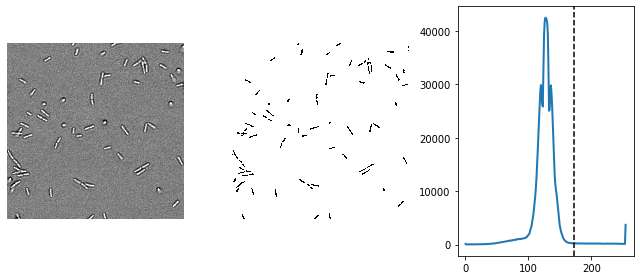

In [ ]:
#TESTING SPACE

import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure

# camera = data.camera()
camera = img
val = filters.threshold_otsu(camera)

hist, bins_center = exposure.histogram(camera)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(camera < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

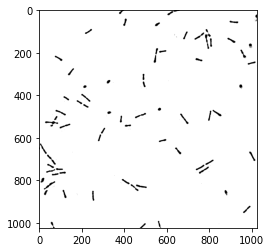

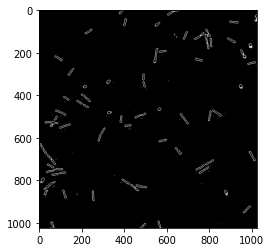

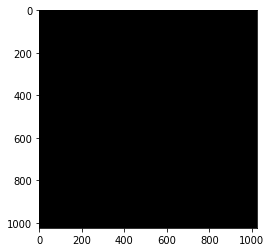

In [ ]:
#MORE TESTING
tmp_img = test_img

plt.figure()
plt.imshow(tmp_img,cmap='gray')
plt.show()
toDisp = ndimage.filters.laplace(tmp_img)
plt.imshow(toDisp,cmap='gray')
plt.show()
toDisp = ndimage.filters.gaussian_laplace(tmp_img, 1)
plt.imshow(toDisp,cmap='gray')
plt.show()

In [ ]:
import os
import glob
# !ls '/content/drive/My Drive/cs168/train/rename'
#'/content/drive/My Drive/cs168/rename/test(1)'
folder_path = '/content/drive/My Drive/cs168/train/Centroids'
img_dir = folder_path # Enter Directory of all images 
data_path = os.path.join(img_dir,'*')
files = glob.glob(data_path)
onesParIndex = 89
tensParIndex = onesParIndex + 1
for f1 in files:
  if (f1[onesParIndex] == ')'):
    newStr = f1[:onesParIndex - 1] + "00" + f1[onesParIndex - 1:]
    os.rename(f1, newStr)
  elif (f1[onesParIndex + 1] == ')'):
    newStr = f1[:onesParIndex - 1] + '0' + f1[onesParIndex - 1:]
    os.rename(f1, newStr)
# os.rename(r'/content/drive/My Drive/cs168/train/rename/test(01).gdoc',r'/content/drive/My Drive/cs168/train/rename/test(1).gdoc')